# Load Modeuls and Set `matplotlib` Parameters

In [2]:
# Copyright 2023 wngfra.
# SPDX-License-Identifier: Apache-2.0

%load_ext autoreload
%autoreload 2

import importlib
import os
import pickle
from typing import Optional

import matplotlib
import matplotlib.pyplot as plt
import nengo
import numpy as np
import pandas as pd
from IPython.lib.deepreload import reload
from learning_rules import SDSP
from nengo_extras.graphviz import net_diagram
from nengo_extras.matplotlib import imshow
from nengo_extras.plot_spikes import plot_spikes
from numpy import linalg
from scipy import ndimage
from sklearn.decomposition import PCA
from sklearn.inspection import DecisionBoundaryDisplay
from sklearn.metrics import ConfusionMatrixDisplay, confusion_matrix
from sklearn.neighbors import KNeighborsClassifier

%matplotlib widget

save2fig = False

font = {"weight": "normal", "size": 25}
matplotlib.rc("font", **font)
if save2fig:
    matplotlib.rc("xtick", color="white")
    matplotlib.rc("ytick", color="white")
    matplotlib.rc("text", color="white")
else:
    matplotlib.rc("xtick", color="black")
    matplotlib.rc("ytick", color="black")
    matplotlib.rc("text", color="black")

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


# Define Bar Generator and Auxiliary Functions for Nengo Simulation

In [3]:
class BarGenerator:
    def __init__(self, shape):
        self._shape = np.asarray(shape)

    def __call__(self, shift=None, angle=0, dim=(1, 1)):
        """Generate a bar with given shape.

        Args:
            shift (tuple, optional): Shift of the bar centre. Defaults to image centre.
            angle (float, optional): Angle of the bar. Defaults to 0.
            dim (tuple, optional): Dimension of the bar. Defaults to (1, 1).

        Returns:
            np.ndarray: Bar with shape (width, shape[1]).
        """
        # Compute the new side length for the padded image
        L = linalg.norm(self.shape).astype(int)
        if L % 2 == 0:
            L += 1
        padded = np.zeros((L, L))
        if dim[0] > L or dim[1] > L:
            raise ValueError("Bar dimension is larger than image size.")
        padded[
            L // 2 - dim[0] // 2 : L // 2 - dim[0] // 2 + dim[0],
            L // 2 - dim[1] // 2 : L // 2 - dim[1] // 2 + dim[1],
        ] = 1
        padded = ndimage.rotate(padded, angle)
        if shift:
            padded = ndimage.shift(padded, shift)
        padbottom, padleft = (padded.shape - self.shape) // 2

        cropped = padded[
            padbottom : padbottom + self.shape[0], padleft : padleft + self.shape[1]
        ]

        cropped[cropped < 0.1] = 0
        cropped /= cropped.max() if cropped.max() > 0 else 1

        return cropped

    @property
    def shape(self):
        return self._shape

    @shape.setter
    def shape(self, shape):
        self._shape = shape

    def generate_samples(
        self, num_samples, dim, shift=None, start_angle=0, step=1, add_test=False
    ):
        bars = [self(shift, start_angle + i * step, dim) for i in range(num_samples)]
        info = np.arange(start_angle, start_angle + num_samples * step, step)
        bars = np.asarray(bars)
        info = np.asarray(info)
        if add_test:
            rng = np.random.default_rng(seed=0)
            arr = np.arange(num_samples, dtype=int)
            np.random.shuffle(arr)
            bars = np.concatenate((bars, bars[arr]))
            info = np.concatenate((info, info[arr]))
        return bars, info


def gen_transform(pattern=None, **kwargs):
    def inner(shape):
        """Closure of the transform matrix generator.

        Args:
            shape (array_like): Linear transform mapping of shape (size_out, size_mid).
        Returns:
            inner: Function that returns the transform matrix.
        """
        W = np.zeros(shape)

        match pattern:
            case "uniform_inhibition":
                assert shape[0] == shape[1], "Transform matrix is not symmetric!"
                W = -np.ones(shape) + 2 * np.eye(shape[0])
            case "circular_inhibition":
                # For self-connections
                assert shape[0] == shape[1], "Transform matrix is not symmetric!"
                weight = np.abs(np.arange(shape[0]) - shape[0] // 2)
                for i in range(shape[0]):
                    W[i, :] = np.roll(weight, i + shape[0] // 2 + 1)
                W = -W + np.eye(shape[0])
            case 0:
                pass
            case _:
                W = np.random.randint(0,2,W.shape)
        return W

    return inner

# Create Nengo Network and Run Simulation

## Spike-Driven Synaptic Dynamics
1. The calcium variable $C(t)$ is a function of postsynaptic spiking activity with a long time constant, $$\frac{dC(t)}{dt} = -\frac{1}{\tau_C} C(t) + J_C \sum_i \delta(t - t_i)$$
2. The $X(t)$ is restricted to $X_{min} \leq X \leq X_{max}$ and is dependent on $C(t)$. When a presynaptic spike arrives at time $t_{pre}$, the variable $X$ updates by
$$X \rightarrow X + a \quad \text{if} \quad V(t_{pre}) > \theta_V \quad \text{and} \quad \theta^l_{up} < C(t_{pre}) < \theta^h_{up}$$
$$X \rightarrow X - b \quad \text{if} \quad V(t_{pre}) \leq \theta_V \quad \text{and} \quad \theta^l_{down} < C(t_{pre}) < \theta^h_{down}$$
3. When there is no presynaptic spiking acvitity or the above conditions are not met, the internal state $X$ drifts towards the bistable states according to
$$\frac{dX}{dt} = \alpha \quad \text{if} \quad X > \theta_X$$
$$\frac{dX}{dt} = -\beta \quad \text{if} \quad X \leq \theta_X$$
4. At the time $t_{pre}$ the synaptic efficacy (weight) is updated to $J_{ex}$ if $X > \theta_X$ or instead $0$ if $X \leq \theta_X$. 

HtmlProgressBar cannot be displayed. Please use the TerminalProgressBar. It can be enabled with `nengo.rc['progress']['progress_bar'] = 'nengo.utils.progress.TerminalProgressBar'`.

HtmlProgressBar cannot be displayed. Please use the TerminalProgressBar. It can be enabled with `nengo.rc['progress']['progress_bar'] = 'nengo.utils.progress.TerminalProgressBar'`.

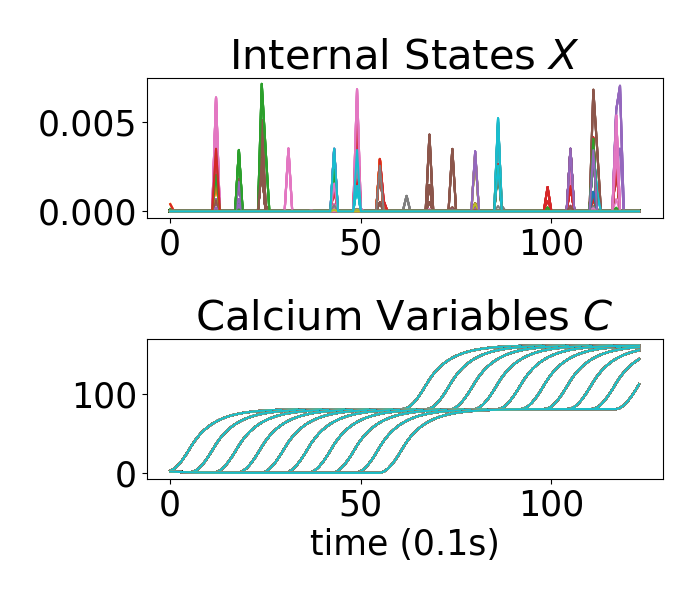

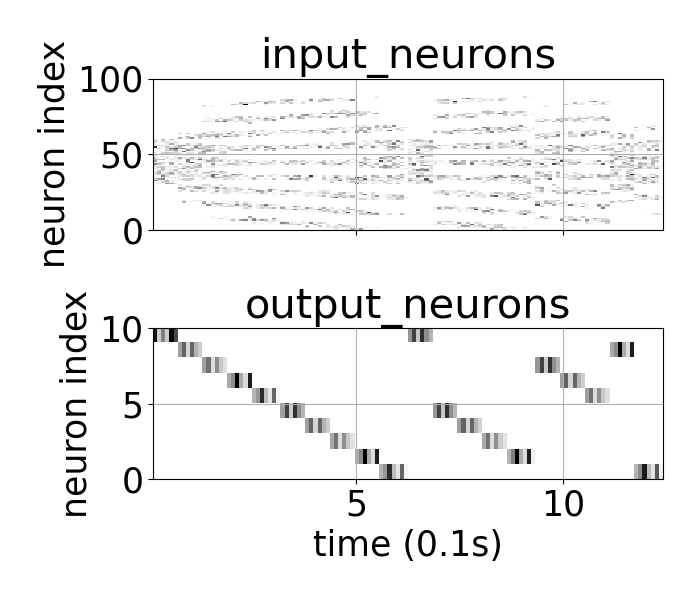

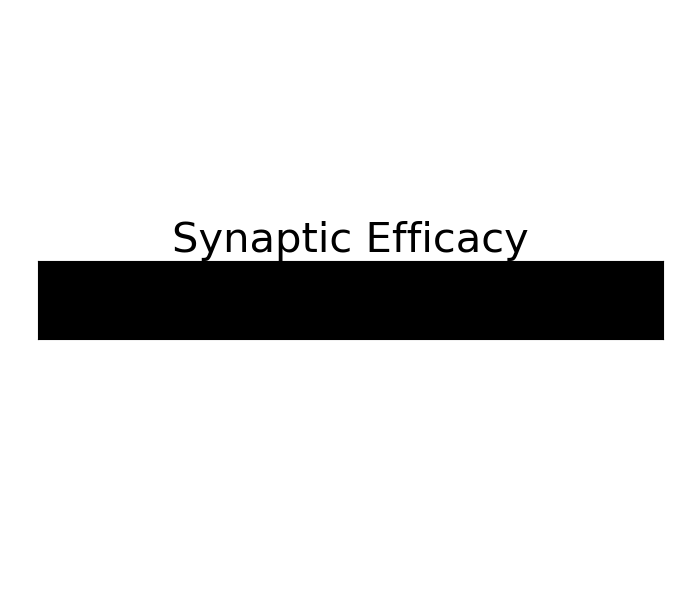

In [20]:
stim_shape = (10, 10)
stim_size = np.prod(stim_shape)
num_samples = 10

# Prepare dataset
bg = BarGenerator(stim_shape)
X_in, y_in = bg.generate_samples(
    num_samples=num_samples,
    dim=(3, 10),
    shift=(0, 0),
    start_angle=0,
    step=180 / num_samples,
    add_test=True,
)

# Simulation parameters
dt = 1e-3
n_output = 10
decay_time = 2e-2
presentation_time = 0.6 + decay_time
duration = X_in.shape[0] * presentation_time
sample_every = 100 * dt
learning_rule_option = SDSP(
    J_C=5,
    tau_c=6e-1,
    X_coeff=(0.1, 0.1, 3.5, 3.5),  # (a, b, alpha, beta)
    theta_coeff=(13, 3, 4, 3),  # (theta_hup, theta_lup, theta_hdown, theta_ldown)
)

# Default neuron parameters
max_rate = 50 # Hz
amp = 1.0
tau_rc = 0.02
rate_target = max_rate * amp  # must be in amplitude scaled units
default_neuron = nengo.AdaptiveLIF(amplitude=amp, tau_rc=tau_rc)
default_rates = nengo.dists.Choice([rate_target])
default_intercepts = nengo.dists.Choice([0])
default_encoders = nengo.dists.ScatteredHypersphere(surface=True)


def stim_func(t):
    Xid = int(t / presentation_time) % len(X_in)
    stage = t - int(t / presentation_time) * presentation_time
    sample = X_in[Xid].ravel()
    if stage <= presentation_time - decay_time:
        return sample
    else:
        return np.zeros_like(sample)


def target_func(t):
    target = y_in[int(t / presentation_time) % len(y_in)]
    stage = t - int(t / presentation_time) * presentation_time
    if stage <= presentation_time - decay_time:
        n_target = int(target / (180 / n_output))
        spike = -np.ones(n_output)
        spike[n_target] = 1
        return spike
    else:
        return np.zeros(n_output)


# Define layers
layer_confs = [
    # Input/Visual layers
    dict(
        name="orientation",
        neuron=None,
        output=target_func,
    ),
    dict(
        name="stimulus",
        neuron=None,
        output=stim_func,
    ),
    dict(
        name="input",
        neuron=nengo.PoissonSpiking(nengo.LIFRate(tau_rc=tau_rc, amplitude=amp)),
        n_neurons=stim_size,
        dimensions=1,
    ),
    dict(
        name="target",
        n_neurons=n_output,
    ),
    dict(
        name="output",
        n_neurons=n_output,
        dimensions=1,
    ),
    dict(
        name="learning_switch",
        neuron=None,
        output=lambda t: True if t < duration else False,
    ),
]

# Define connections
conn_confs = [
    # Input/Visual connections
    dict(
        pre="stimulus",
        post="input_neurons",
        transform=1,
        synapse=0,
    ),
    dict(
        pre="orientation",
        post="target_neurons",
        transform=1,
        synapse=0,
    ),
    dict(
        pre="input_neurons",
        post="output_neurons",
        transform=gen_transform(0),
        learning_rule=learning_rule_option,
        synapse=1e-3,
    ),
    dict(
        pre="output_neurons",
        post="output_neurons",
        transform=gen_transform("uniform_inhibition"),
        synapse=0,
    ),
    dict(
        pre="target_neurons",
        post="output_neurons",
        transform=1,
        synapse=0,
    ),
]


learning_confs = []

# Create the Nengo model
with nengo.Network(label="tacnet", seed=1) as model:
    layers = dict()
    connections = dict()
    probes = dict()

    # Create layers
    for k, layer_conf in enumerate(layer_confs):
        layer_conf = dict(layer_conf)  # Copy configuration
        name = layer_conf.pop("name")
        n_neurons = layer_conf.pop("n_neurons", 1)
        dimensions = layer_conf.pop("dimensions", 1)
        encoders = layer_conf.pop("encoders", default_encoders)
        max_rates = layer_conf.pop("max_rates", default_rates)
        radius = layer_conf.pop("radius", 1.0)
        neuron_type = layer_conf.pop("neuron", default_neuron)
        on_chip = layer_conf.pop("on_chip", False)
        block = layer_conf.pop("block", None)
        output = layer_conf.pop("output", None)
        size_in = layer_conf.pop("size_in", None)

        assert len(layer_conf) == 0, "Unused fields in {}: {}".format(
            [name], list(layer_conf)
        )

        if neuron_type is None:
            assert not on_chip, "Nodes can only be run off-chip"

            layer = nengo.Node(output=output, size_in=size_in, label=name)
            layers[name] = layer
            probe = nengo.Probe(
                layer, synapse=0.01, sample_every=sample_every, label="%s_probe" % name
            )
            probes[name] = probe
        else:
            layer = nengo.Ensemble(
                n_neurons,
                dimensions=dimensions,
                radius=radius,
                encoders=encoders,
                intercepts=default_intercepts,
                neuron_type=neuron_type,
                max_rates=max_rates,
                normalize_encoders=True,
                label=name,
            )
            layers[name] = layer
            layers[name + "_neurons"] = layer.neurons

            # Add a probe so we can measure individual layer rates
            probe = nengo.Probe(
                layer, synapse=0.01, sample_every=sample_every, label="%s_probe" % name
            )
            probes[name] = probe
            probe = nengo.Probe(
                layer.neurons,
                synapse=0.01,
                sample_every=sample_every,
                label="%s_neurons_probe" % name,
            )
            probes[name + "_neurons"] = probe

    for k, conn_conf in enumerate(conn_confs):
        conn_conf = dict(conn_conf)
        pre = conn_conf.pop("pre")
        post = conn_conf.pop("post")
        dim_in = conn_conf.pop("dim_in", None)
        dim_out = conn_conf.pop("dim_out", None)
        synapse = conn_conf.pop("synapse", None)
        solver = conn_conf.pop("solver", None)
        transform = conn_conf.pop("transform", None)
        learning_rule = conn_conf.pop("learning_rule", None)
        name = "{}2{}".format(pre, post)
        function = conn_conf.pop("function", None)

        assert len(conn_conf) == 0, "Unused fields in {}: {}".format(
            [name], list(layer_conf)
        )
        if dim_in is None:
            pre_conn = layers[pre]
        else:
            pre_conn = layers[pre][dim_in]
        if dim_out is None:
            post_conn = layers[post]
        else:
            post_conn = layers[post][dim_out]
        if callable(transform):
            transform = transform((post_conn.size_in, pre_conn.size_in))
        conn = nengo.Connection(
            pre_conn,
            post_conn,
            function=function,
            transform=transform,
            synapse=synapse,
            label=name,
        )
        if solver:
            conn.solver = solver
        if learning_rule:
            conn.learning_rule_type = learning_rule
            name_ = name + "_X"
            probes[name_] = nengo.Probe(
                conn.learning_rule,
                "X",
                synapse=0.01,
                sample_every=sample_every,
                label=f"{name_}",
            )
            name_ = name + "_C"
            probes[name_] = nengo.Probe(
                conn.learning_rule,
                "C",
                synapse=0.01,
                sample_every=sample_every,
                label=f"{name_}",
            )
        connections[name] = conn

        # Probe weights
        name_ = name + "_weights"
        probes[name_] = nengo.Probe(
            conn,
            "weights",
            synapse=0.01,
            sample_every=sample_every,
            label=f"{name_}",
        )

    # Connect learning rule
    for k, learning_conf in enumerate(learning_confs):
        learning_conf = dict(learning_conf)
        pre = learning_conf.pop("pre")
        post = learning_conf.pop("post")
        transform = learning_conf.pop("transform", 1)
        nengo.Connection(
            layers[pre],
            connections[post].learning_rule,
            transform=transform,
        )


def main(plot=False, savedata=False):
    with nengo.Simulator(model, dt=dt, optimize=True) as sim:
        sim.run(duration)

    ens_names = ["input_neurons", "output_neurons"]
    conn_names = [f"{ens_names[0]}2{ens_names[1]}"]

    if plot:
        plt.close("all")
        # Raster plot neuronal activities
        _, axs = plt.subplots(
            len(ens_names), 1, figsize=(3.5 * len(ens_names), 6), sharex=True
        )
        for i, ens_name in enumerate(ens_names):
            plot_spikes(
                sim.trange(sample_every=sample_every),
                sim.data[probes[ens_name]],
                ax=axs[i],
            )
            axs[i].set_ylabel("neuron index")
            axs[i].set_title(ens_name)
            axs[i].grid()
        plt.xlabel(f"time ({sample_every}s)")
        plt.tight_layout()

        # Plot synapses and plasticity
        for conn_name in conn_names:
            plt.figure(figsize=(7, 6))
            imshow(
                sim.data[probes[conn_name + "_weights"]].reshape(
                    -1, n_output * stim_size
                )
            )
            plt.xlabel(f"time ({sample_every}s)")
            plt.tight_layout()
            plt.title("Synaptic Efficacy")

            if learning_rule_option:
                _, axs = plt.subplots(2, 1, figsize=(7, 6))
                axs[0].plot(
                    sim.data[probes[conn_name + "_X"]].reshape(-1, n_output * stim_size)
                )
                axs[1].plot(
                    sim.data[probes[conn_name + "_C"]].reshape(-1, n_output * stim_size)
                )
                axs[0].set_title(f"Internal States $X$")
                axs[1].set_title(f"Calcium Variables $C$")
                plt.xlabel(f"time ({sample_every}s)")
                plt.tight_layout()

        plt.show(block=False)

    if savedata:
        stimuli = sim.data[probes["input_neurons"]]
        targets = sim.data[probes["target_neurons"]]
        return stimuli, targets


if __name__ == "__main__":
    stimuli, targets = main(plot=True, savedata=True)

# Visualize Classification of Stimulus Patterns

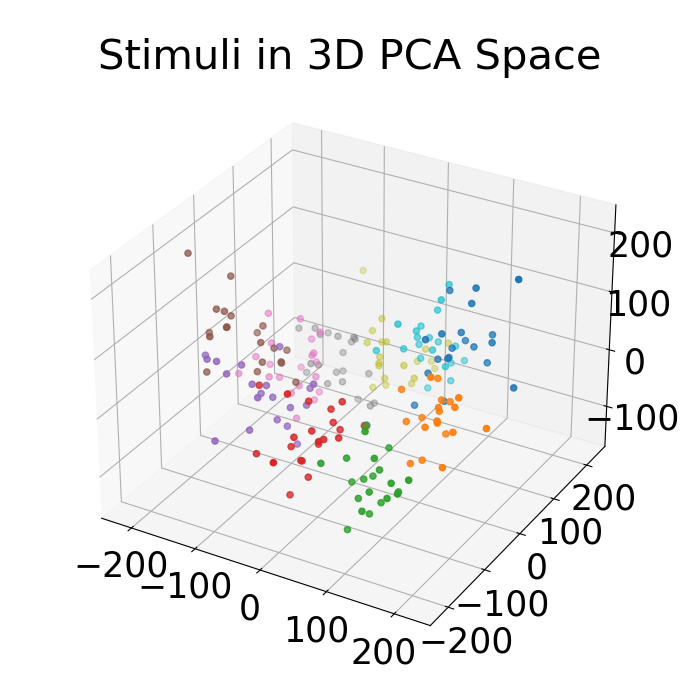

In [6]:
n_neighbours = 10
clf = KNeighborsClassifier(n_neighbors=n_neighbours, weights="distance")
X = stimuli
y = np.argmax(targets, axis=1)
X_train = X[: int(0.5 * X.shape[0])]
y_train = y[: int(0.5 * X.shape[0])]
X_test = X[int(0.5 * X.shape[0]) :]
y_test = y[int(0.5 * X.shape[0]) :]

pca = PCA(n_components=3)
X_new = pca.fit_transform(X)
clf.fit(X_train, y_train)
y_pred = clf.predict(X_test)

cmap = matplotlib.colormaps["viridis"].resampled(n_neighbours)

fig = plt.figure(figsize=(7, 7))
ax = fig.add_subplot(projection="3d")
ax.scatter3D(*X_new.T, c=y, cmap="tab10", s=20)
plt.title("Stimuli in 3D PCA Space")
plt.tight_layout()
plt.show()

# Visualize Input Stimuli

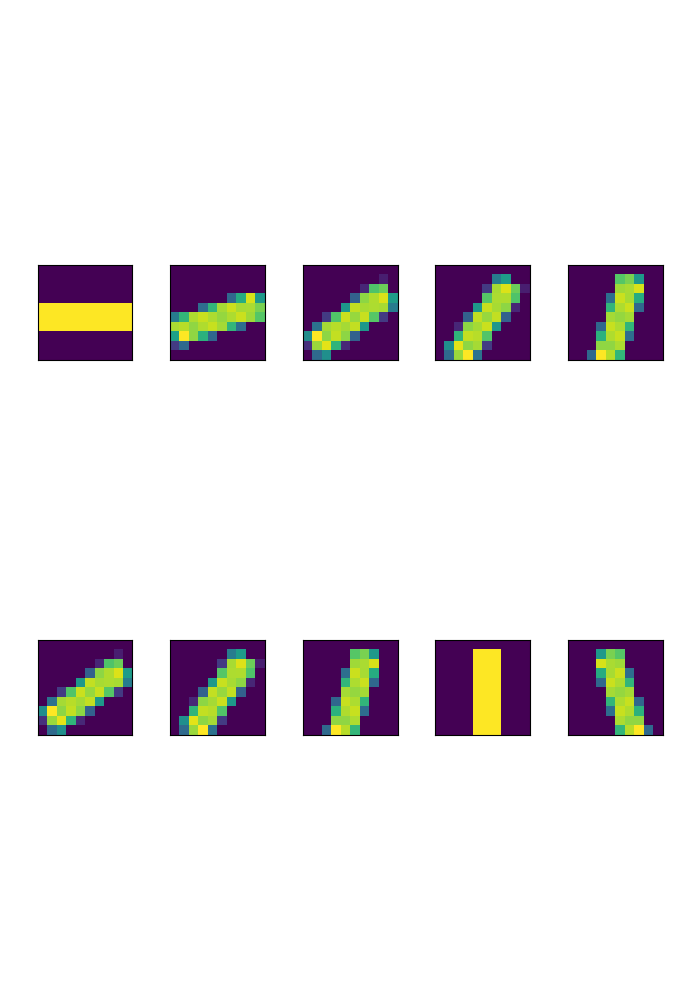

In [34]:
# Plot generated bars
shape = (10, 10)
bg = BarGenerator(shape)
num_samples = 10
bars, tags = bg.generate_samples(
    num_samples=num_samples,
    dim=(3, 10),
    shift=(0, 0),
    start_angle=0,
    step=180 / num_samples,
)
nrows, ncols = 2, 5
plt.close("all")
fig, axs = plt.subplots(nrows, ncols, figsize=(7, 10))
for i in range(nrows):
    for j in range(ncols):
        index = i * nrows + j
        axs[i, j].imshow(bars[index])
        axs[i, j].set_title(rf"angle {tags[index]}$^\circ$", color="w")
        axs[i, j].set_xticks([])
        axs[i, j].set_yticks([])
plt.tight_layout()

if os.path.isdir("figs"):
    filepath = os.path.join(plotpath, "bars.png")
    plt.savefig(filepath, dpi=600, transparent=True)

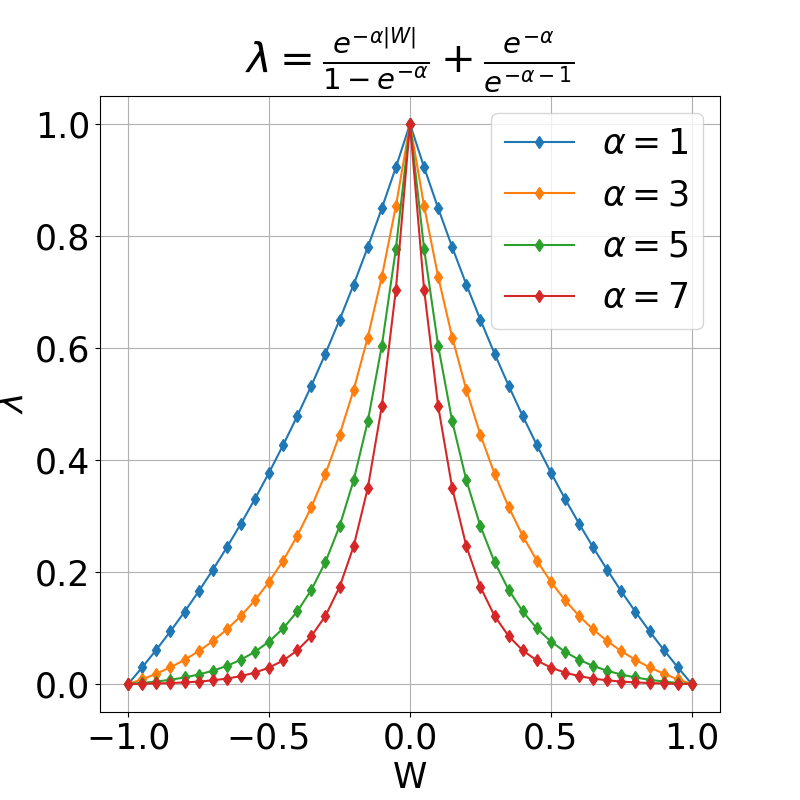

In [26]:
plt.figure(figsize=(8, 8))
alphas = np.arange(1, 9, 2)
for alpha in alphas:
    beta = np.exp(-alpha)
    a = 1 / (1 - beta)
    b = beta / (beta - 1)
    x = np.linspace(-1, 1, 41)
    y = a * np.exp(-alpha * np.abs(x)) + b
    plt.plot(x, y, marker="d", label=rf"$\alpha={alpha}$")
plt.ylabel(r"$\lambda$")
plt.xlabel("W")
plt.title(
    r"$\lambda = \frac{e^{-\alpha |W|}}{1 - e^{-\alpha}} + \frac{e^{-\alpha}}{e^{-\alpha - 1}}$"
)
plt.grid()
plt.legend()
plt.show()